# import and dataset

In [1]:
import shutil
shutil.rmtree('cultural_classification_nlp', ignore_errors=True)

!git clone "https://github.com/cybernetic-m/cultural_classification_nlp.git"
!pip install --quiet wikipedia wikidata datasets 2> /dev/null    # the 2> /dev/null redirects standard error to the null avoiding the print of dependencies conflicts

# Drive mounting
from google.colab import drive
drive.mount('/content/drive')

from wikidata.client import Client
import wikipedia
from datasets import load_dataset
from huggingface_hub import login
import pandas as pd
import json
from collections import OrderedDict
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import requests
import time
from sklearn.preprocessing import LabelEncoder
import networkx as nx
import matplotlib.pyplot as plt


from cultural_classification_nlp.graph.src.save_and_load import save_encoder, load_encoder, save_graph, load_graph
from cultural_classification_nlp.graph.src.test import test, eval_non_lm
from cultural_classification_nlp.graph.src.process_data import process_df
from cultural_classification_nlp.src.utils import id2string, print_labels_counts

from cultural_classification_nlp.graph.src.graph import make_graph, prepare_data

Cloning into 'cultural_classification_nlp'...
remote: Enumerating objects: 602, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 602 (delta 64), reused 83 (delta 27), pack-reused 468 (from 1)
Receiving objects: 100% (602/602), 10.35 MiB | 3.69 MiB/s, done.
Resolving deltas: 100% (297/297), done.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.6 MB/s eta 0:00:00


# Login to HuggingFace and Download dataset
- To download the dataset you need to have an HuggingFace account. Please create it: https://huggingface.co/
- You need to have a token: in this page https://huggingface.co/settings/tokens create a token called "notebooks" with "write" permissions. Then copy the key into the Token: cell!

In [2]:
login()

In [3]:
dataset = load_dataset('sapienzanlp/nlp2025_hw1_cultural_dataset')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.31k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/946k [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/45.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6251 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/300 [00:00<?, ? examples/s]

In [4]:
df = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['validation'])

# useful label study

With the code below we searched for data that is spreaded differently across the 3 labels.

In [5]:
try:
  path_train_processed = '/content/drive/MyDrive/Caponata_Lovers_shared_folder/processed_df_train.csv'
  path_val_processed = '/content/drive/MyDrive/Caponata_Lovers_shared_folder/processed_df_validation.csv'

  my_train_df = pd.read_csv(path_train_processed)
  my_val_df = pd.read_csv(path_val_processed)

except:
  path_train_processed = '/content/cultural_classification_nlp/wikipedia_data/processed_df_train.csv'
  path_val_processed = '/content/cultural_classification_nlp/wikipedia_data/processed_df_validation.csv'

  my_train_df = pd.read_csv(path_train_processed)
  my_val_df = pd.read_csv(path_val_processed)

Here we search for properties that is present from 500 to 6000 elements in the df

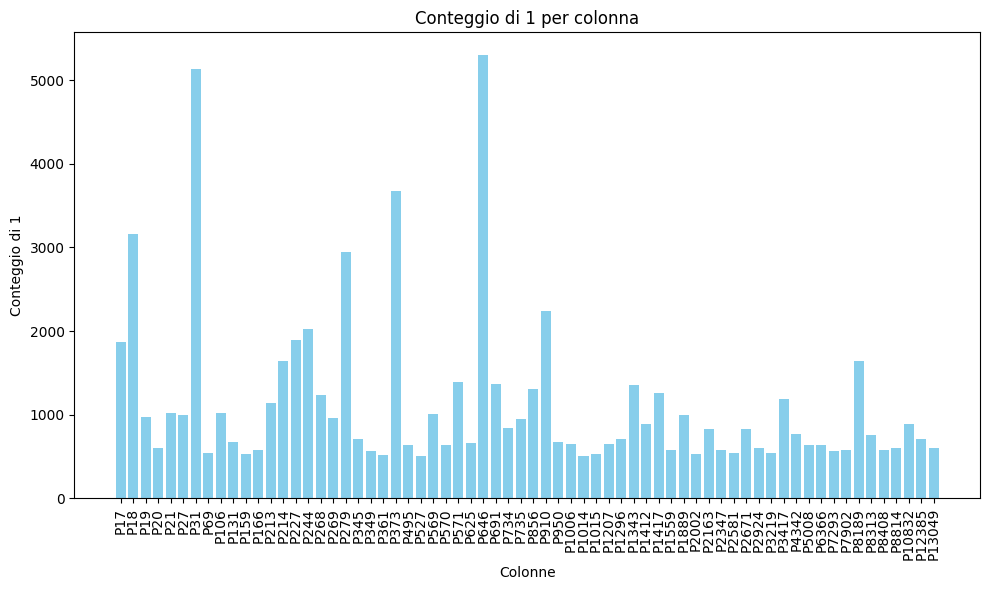

In [6]:
columns_to_analyze = [col for col in my_train_df.columns if col.startswith('P')]

counts_of_1 = {}

for col in columns_to_analyze:
    sum = my_train_df[col].sum()
    if  500 < sum < 6000:
       counts_of_1[col] = sum
plt.figure(figsize=(10, 6))
plt.bar(counts_of_1.keys(), counts_of_1.values(), color='skyblue')
plt.title('Conteggio di 1 per colonna')
plt.xlabel('Colonne')
plt.ylabel('Conteggio di 1')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Here we print the properties and how many of them is in each class

In [7]:
client = Client()

sorted_counts = sorted(counts_of_1.items(), key=lambda item: item[1], reverse=True)
#print(len(sorted_counts))

ok = True
for elem, count in sorted_counts:
    print('\n\n', elem, id2string(elem, client), count)
    print_labels_counts(my_train_df, elem)



66


 P646 Freebase ID 5306
     - label
0    2254
1    1513
2    1539
Name: label, dtype: int64


 P31 instance of 5132
     - label
0    2401
1    1520
2    1211
Name: label, dtype: int64


 P373 Commons category 3671
     - label
0    1526
1    1126
2    1019
Name: label, dtype: int64


 P18 image 3165
     - label
0    1334
1    1023
2     808
Name: label, dtype: int64


 P279 subclass of 2940
     - label
0     739
1     586
2    1615
Name: label, dtype: int64


 P910 topic's main category 2236
     - label
0    686
1    703
2    847
Name: label, dtype: int64


 P244 Library of Congress authority ID 2028
     - label
0    818
1    731
2    479
Name: label, dtype: int64


 P227 GND ID 1890
     - label
0    736
1    658
2    496
Name: label, dtype: int64


 P17 country 1873
     - label
0    1413
1     364
2      96
Name: label, dtype: int64


 P8189 J9U ID 1647
     - label
0    566
1    600
2    481
Name: label, dtype: int64


 P214 VIAF cluster ID 1637
     - label
0    956
1   

# Training

First of all we started by making label encoders for the category and sub category:

In [8]:
all_categories = df['category']
all_subcategories = df['subcategory']

# Initialize and fit the LabelEncoders on the combined data
category_encoder = LabelEncoder().fit(all_categories)
subcategory_encoder = LabelEncoder().fit(all_subcategories)

In [9]:
save_encoder(category_encoder, 'category_encoder.pkl')
save_encoder(subcategory_encoder, 'subcategory_encoder.pkl')


To create the processed dataset (in which we have added wikipedia and wikimedia data) we have done something like:
```
encoders_path='./cultural_classification_nlp/graph/models'
my_train_df = process_df(df, path = encoders_path, labels_flag=True)
my_train_df.to_csv('processed_df_train.csv', index=False)
```
In this notebook (for time reasons) we download from colab the processed dataset in csv format.

The following lines will load the dataframes we got from the process_df functions, this is for you to save time since running the process_df can need minutes based on the connection speed and number of elements to process

In [10]:
try:
  path_train_processed = '/content/drive/MyDrive/Caponata_Lovers_shared_folder/processed_df_train.csv'
  path_val_processed = '/content/drive/MyDrive/Caponata_Lovers_shared_folder/processed_df_validation.csv'

  my_train_df = pd.read_csv(path_train_processed)
  my_val_df = pd.read_csv(path_val_processed)

except:
  path_train_processed = '/content/cultural_classification_nlp/wikipedia_data/processed_df_train.csv'
  path_val_processed = '/content/cultural_classification_nlp/wikipedia_data/processed_df_validation.csv'

  my_train_df = pd.read_csv(path_train_processed)
  my_val_df = pd.read_csv(path_val_processed)

The following lines are for making a new graph based on a training dataframe, the last parameter set to True means that we are adding the labels to the entity nodes

In [11]:
G = nx.Graph()
make_graph(G, my_train_df, True)

# Testing

The following lines are for loading the graph we have already made with only the training data.

**⚠️TAs Instructions⚠️**: If you are doing tests and want to make a new graph you can just comment the second line and use the graph and data that you can make following the instructions in the training section.

In [12]:
# comment this line if you want to make the training graph yourself
G = load_graph('cultural_graph')
# adds the new elements to the graph already made of the training data, without labels, the labels are set to -1 (to be predicted)
make_graph(G, my_val_df, False)


Carico da: /content/cultural_classification_nlp/graph/models/cultural_graph


**⚠️TAs Instructions⚠️**: Here you can test the label propagation on the graph, you can try to change the parameters on the test function by specifying if you want to use "RBF" or "KNN" and their values.

```
    Inputs:
    - A: scipy sparse matrix representing the adjacency matrix of the graph
    - y: array of node labels (with -1 for unlabeled nodes)
    - node_idx: dictionary mapping node names to their indices
    - X_test: list of test node names (qids)
    - y_test: list of true labels for test nodes
    - kernel: type of kernel to use ('knn' or 'rbf')
    - gamma: gamma value for 'rbf' kernel
    - n_neighbors: number of neighbors for 'knn' kernel
    - print_statistics: boolean to print evaluation metrics (confusion matrix, classification report)

```

Accuracy su nodi di test: 0.7367


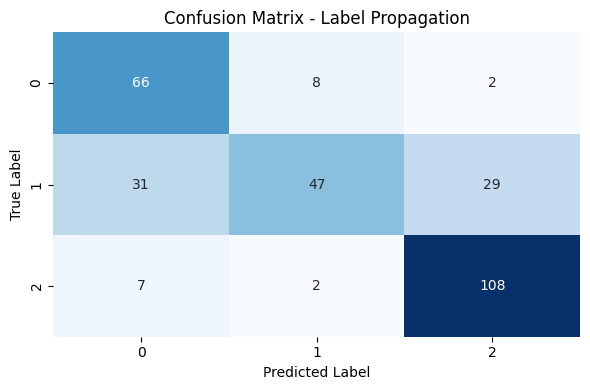


Classification Report:
              precision    recall  f1-score   support

           0     0.6346    0.8684    0.7333        76
           1     0.8246    0.4393    0.5732       107
           2     0.7770    0.9231    0.8438       117

    accuracy                         0.7367       300
   macro avg     0.7454    0.7436    0.7168       300
weighted avg     0.7579    0.7367    0.7193       300



In [13]:
X_test = my_val_df["qid"].tolist()
if 'label' in my_val_df.columns:
    labels_flag = True
    # if the test set has labels, we take them from the dataframe
    y_test = my_val_df["label"].tolist()
else:
    labels_flag = False
    # if the test set has no labels, we create a list of -1
    y_test = [-1] * len(X_test)


# this will make the adjacency matrix, values to predict and a mapping from node names to their index in the graph
A, y, node_idx = prepare_data(G)

# returns a df with qid and predictions and the dataframe used for the graph
predictions_df, _ = test(A = A, y = y, node_idx = node_idx, X_test = X_test, y_test = y_test, kernel = 'knn', gamma = 10, n_neighbors = 10, print_statistics  = True, labels_flag=labels_flag)
